In [1]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

In [2]:
!pip install opencv-python -q

In [3]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, accuracy_score

In [5]:
def load_images_for_imagenet_model(folder):
    X, y = [], []
    for label, idx in [('female', 0), ('male', 1)]:
        subdir = os.path.join(folder, label)
        for fname in os.listdir(subdir):
            path = os.path.join(subdir, fname)
            img = cv2.imread(path)
            if img is None: continue
            img = cv2.resize(img, (224, 224))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = preprocess_input(img.astype(np.float32))
            X.append(img)
            y.append(idx)
    return np.array(X), to_categorical(y)

# Load datasets
train_path = "/content/drive/MyDrive/data/train"
val_path = "/content/drive/MyDrive/data/val"

X_train, y_train = load_images_for_imagenet_model(train_path)
X_val, y_val = load_images_for_imagenet_model(val_path)

print(f"✅ Loaded {X_train.shape[0]} training images and {X_val.shape[0]} validation images")

✅ Loaded 797 training images and 215 validation images


In [6]:
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # ✅ Enables memory growth
        tf.config.experimental.set_memory_growth(gpus[0], True)
        print("✅ GPU memory growth set.")
    except RuntimeError as e:
        print("❌ Could not set memory growth:", e)
else:
    print("⚠️ No GPU found.")

⚠️ No GPU found.


In [7]:
# Load MobileNetV2 base
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze weights

# Add classifier head
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
outputs = Dense(2, activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         2,562 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,260,546 (8.62 MB)

 Trainable params: 2,562 (10.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)

Epoch 1/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.6692 - loss: 0.6779 - val_accuracy: 0.8372 - val_loss: 0.3708
Epoch 2/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step - accuracy: 0.8540 - loss: 0.3427 - val_accuracy: 0.8512 - val_loss: 0.3392
Epoch 3/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.8747 - loss: 0.2961 - val_accuracy: 0.8465 - val_loss: 0.3204
Epoch 4/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9014 - loss: 0.2563 - val_accuracy: 0.8744 - val_loss: 0.3184
Epoch 5/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9012 - loss: 0.2357 - val_accuracy: 0.8698 - val_loss: 0.3434
Epoch 6/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step - accuracy: 0.9064 - loss: 0.2467 - val_accuracy: 0.8605 - val_loss: 0.3110
Epoch 7/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9109 - loss: 0.2082 - val_accuracy: 0.8698 - val_loss: 0.3062
Epoch 8/10
25/25 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.9292 - loss: 0.1792 - val_accuracy: 0.8698 - val_loss:

In [9]:
model.save("/content/gender_classifier_mobilenetv2.h5")
print("✅ Model saved.")


✅ Model saved.


25/25 ━━━━━━━━━━━━━━━━━━━━ 55s 2s/step

📊 Train Evaluation
✅ Accuracy:  0.9598
✅ Precision: 0.9626
✅ Recall:    0.9578
✅ F1 Score:  0.9602
✅ AUC-ROC:   0.9908

               precision    recall  f1-score   support

      Female       0.96      0.96      0.96       394
        Male       0.96      0.96      0.96       403

    accuracy                           0.96       797
   macro avg       0.96      0.96      0.96       797
weighted avg       0.96      0.96      0.96       797



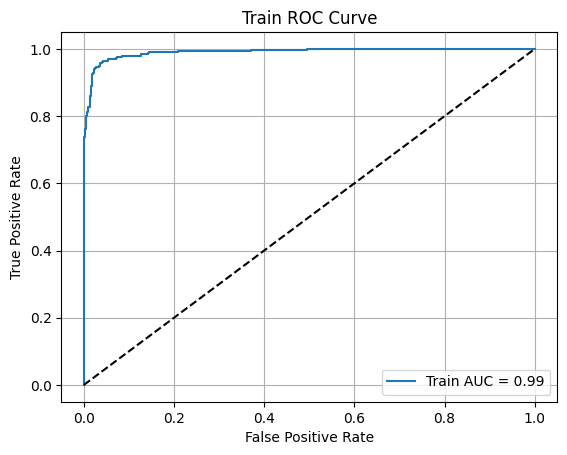

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step

📊 Validation Evaluation
✅ Accuracy:  0.8744
✅ Precision: 0.8487
✅ Recall:    0.9182
✅ F1 Score:  0.8821
✅ AUC-ROC:   0.9519

               precision    recall  f1-score   support

      Female       0.91      0.83      0.87       105
        Male       0.85      0.92      0.88       110

    accuracy                           0.87       215
   macro avg       0.88      0.87      0.87       215
weighted avg       0.88      0.87      0.87       215



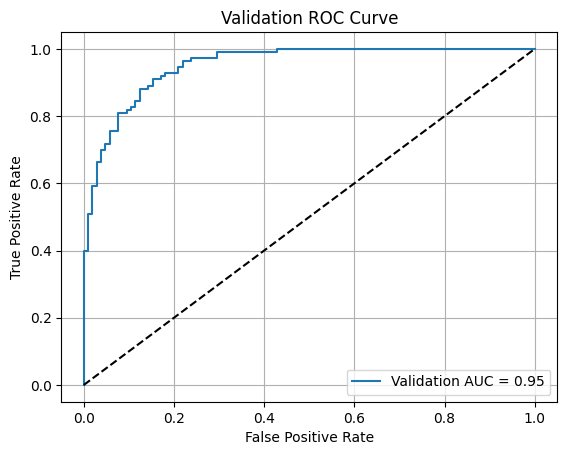

In [10]:
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, roc_auc_score, roc_curve, classification_report
)

def evaluate_model(model, X, y_true_onehot, title="Set"):
    y_true = np.argmax(y_true_onehot, axis=1)
    y_pred_prob = model.predict(X)
    y_pred = np.argmax(y_pred_prob, axis=1)

    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred_prob[:, 1])

    print(f"\n📊 {title} Evaluation")
    print(f"✅ Accuracy:  {acc:.4f}")
    print(f"✅ Precision: {prec:.4f}")
    print(f"✅ Recall:    {rec:.4f}")
    print(f"✅ F1 Score:  {f1:.4f}")
    print(f"✅ AUC-ROC:   {auc:.4f}")
    print("\n", classification_report(y_true, y_pred, target_names=["Female", "Male"]))

    fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
    plt.plot(fpr, tpr, label=f'{title} AUC = {auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title(f'{title} ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

# ✅ Run only for train & val
evaluate_model(model, X_train, y_train, "Train")
evaluate_model(model, X_val, y_val, "Validation")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


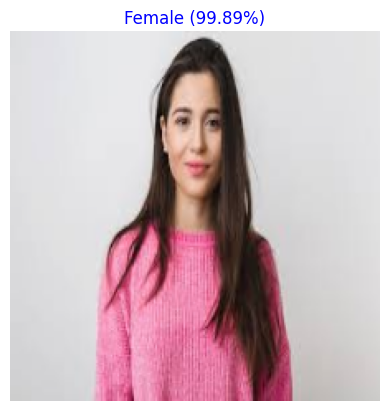

✅ Predicted: Female (Confidence: 99.89%)


In [14]:
def predict_gender(path):
    img = cv2.imread(path)
    if img is None:
        print("❌ Image not found.")
        return
    img_resized = cv2.resize(img, (224, 224))
    img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    img_processed = preprocess_input(img_rgb.astype(np.float32))
    pred = model.predict(np.expand_dims(img_processed, axis=0))[0]

    label = "Male" if pred[1] > pred[0] else "Female"
    confidence = np.max(pred) * 100

    plt.imshow(img_rgb)
    plt.title(f"{label} ({confidence:.2f}%)", color='blue')
    plt.axis('off')
    plt.show()
    print(f"✅ Predicted: {label} (Confidence: {confidence:.2f}%)")

# 🔍 Example usage:
predict_gender("/content/drive/MyDrive/Testcases/Test.jpg")